### Switch to the virtual environment before running the code below

In [2]:
import os
print(os.getcwd())

c:\Users\aashi\OneDrive\Aachu\Data Science\Project\Forecasting Solar Energy Production


### Data Loading and Preparation

In [3]:
import pandas as pd
from prophet import Prophet
from mango import Tuner
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error

c:\Users\aashi\OneDrive\Aachu\Data Science\Project\Forecasting Solar Energy Production\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [7]:
df_train = pd.read_csv('train.csv', 
                    usecols=['date_id', 'Solar'], 
                    parse_dates=['date_id'])
df_test = pd.read_csv('test.csv', 
                   usecols=['date_id', 'Solar'], 
                   parse_dates=['date_id'])

In [8]:
def winsorize_upper(series, upper_percentile=95):
    upper_bound = series.quantile(upper_percentile / 100)
    return series.clip(upper=upper_bound)

df_train['Solar'] = winsorize_upper(df_train['Solar'], upper_percentile=95)


In [9]:
df_train = df_train.rename(columns={'date_id': 'ds', 'Solar': 'y'})
df_test = df_test.rename(columns={'date_id': 'ds', 'Solar': 'y'})


### Baseline Model

In [10]:
baseline_pred = [df_train['y'].mean() for _ in range(len(df_test))]


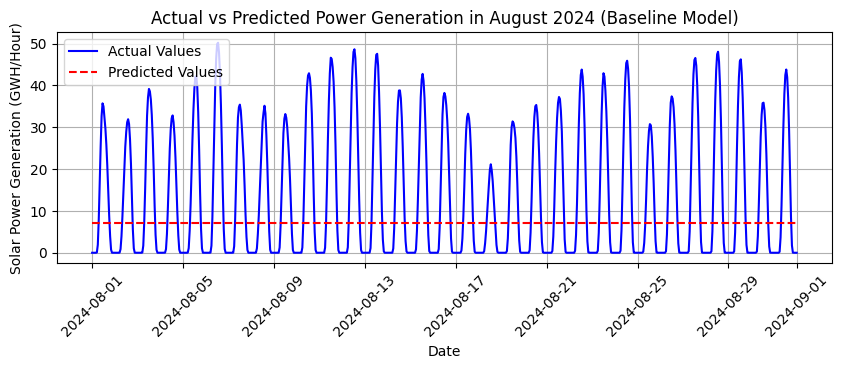

In [23]:
# Plotting
plt.figure(figsize=(10, 3))
plt.plot(df_test['ds'], df_test['y'], label='Actual Values', color='blue')
plt.plot(df_test['ds'], baseline_pred, label='Predicted Values', color='red', linestyle='--')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Solar Power Generation (GWH/Hour)')
plt.title('Actual vs Predicted Power Generation in August 2024 (Baseline Model)')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

# Show plot
plt.show()

In [12]:
error_baseline = root_mean_squared_error(baseline_pred, df_test['y'])
print(f'Root Mean Squared Error of the Baseline Model: {round(error_baseline,2)}')

Root Mean Squared Error of the Baseline Model: 16.63


### Prophet Model on Default Parameters

In [13]:
m = Prophet()
m.fit(df_train)


15:30:58 - cmdstanpy - INFO - Chain [1] start processing
15:31:00 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
df_pred = m.make_future_dataframe(periods=len(df_test), freq='H')
future = m.predict(df_pred)
prophet_basic_pred = future[future['ds']>=df_test['ds'].min()][['ds', 'yhat']]

In [15]:
error_prophet_default = root_mean_squared_error(prophet_basic_pred['yhat'], df_test['y'])
print(f'Root Mean Squared Error of Prophet Model with Default Parameters: {round(error_prophet_default,2)}')

Root Mean Squared Error of Prophet Model with Default Parameters: 7.84


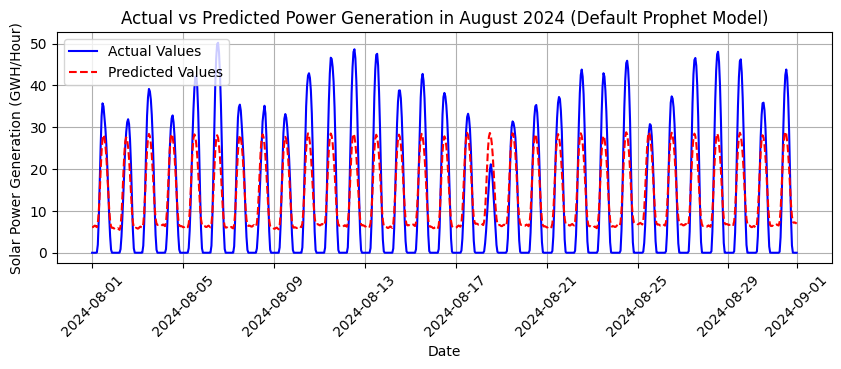

In [24]:
# Plotting
plt.figure(figsize=(10, 3))
plt.plot(df_test['ds'], df_test['y'], label='Actual Values', color='blue')
plt.plot(prophet_basic_pred['ds'], prophet_basic_pred['yhat'], label='Predicted Values', color='red', linestyle='--')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Solar Power Generation (GWH/Hour)')
plt.title('Actual vs Predicted Power Generation in August 2024 (Default Prophet Model)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.show()

### Prophet Model with Hyperparameter Tuning

In [12]:
from scipy.stats import uniform


param_space = dict(growth = ['linear', 'flat'],
                   n_changepoints  = range(0, 55, 5),
                   changepoint_range  = uniform(0.5, 0.5),
                   yearly_seasonality = [True, False],
                   weekly_seasonality = [True, False],
                   daily_seasonality = [True, False],
                   seasonality_mode = ['additive', 'multiplicative'],
                   seasonality_prior_scale=uniform(5.0, 15.0),
                   changepoint_prior_scale=uniform(0.0, 0.1),
                   interval_width = uniform(0.2, 0.8),
                   uncertainty_samples = [500, 1000, 1500, 2000]
                   )

In [17]:

def objective_function(args_list):
    global df_train, df_test
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(df_train)
            future = model.make_future_dataframe(periods=len(df_test), freq='H')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(len(df_test))
            error = root_mean_squared_error(df_test['y'], predictions_tuned['yhat'])   
            
            params_evaluated.append(params)
            results.append(error)
        except Exception as e:
            print(f"Exception raised: {e}")
            #pass 
            params_evaluated.append(params)
            results.append(100.0)# Giving high loss for exceptions regions of spaces
        
        #print(params_evaluated, mse)
    return params_evaluated, results

In [ ]:
# create the conf_dict argument
conf_Dict = dict()
conf_Dict['initial_random'] = 10
conf_Dict['num_iteration'] = 50

# find the best parameters
tuner = Tuner(param_space, objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

In [17]:
# train model
model = Prophet(changepoint_prior_scale=0.0377536382945056, 
               changepoint_range=.5049037429018626,
               daily_seasonality=True,
               growth= 'linear',
               interval_width= 0.22744849128068811,
                n_changepoints= 30,
                seasonality_mode='multiplicative',
                seasonality_prior_scale= 19.99612802489421,
                uncertainty_samples= 1500,
                weekly_seasonality= True,
                yearly_seasonality= True
               )
model.fit(df_train)

# generate predictions
future = model.make_future_dataframe(periods=len(df_test), freq='H')
forecast = model.predict(future)
predictions_tuned_pred = forecast.tail(len(df_test))

15:31:15 - cmdstanpy - INFO - Chain [1] start processing
15:31:18 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
error_prophet_tuned = root_mean_squared_error(df_test['y'], predictions_tuned_pred['yhat'])

In [19]:
print(f'Mean Squared Error after Tuning Prophet Model: {round(error_prophet_tuned,2)}')

Mean Squared Error after Tuning Prophet Model: 4.18


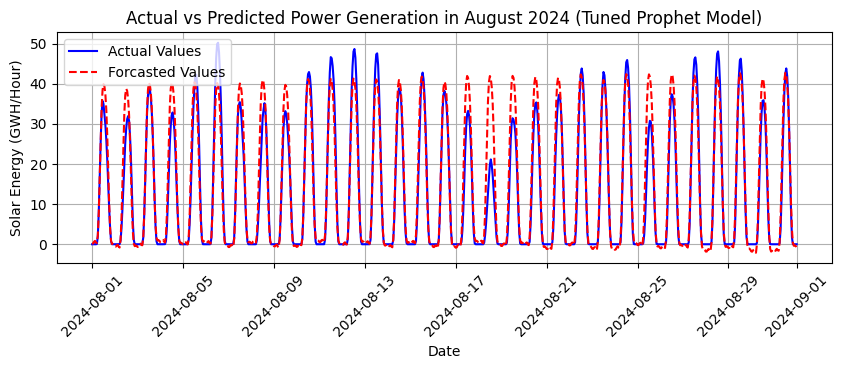

In [22]:
# plot figure
plt.figure(figsize=(10, 3))
plt.plot(df_test['ds'], df_test['y'], label='Actual Values', color='blue')
plt.plot(predictions_tuned_pred['ds'], predictions_tuned_pred['yhat'], label='Forcasted Values', color='red', linestyle='--')

# add labels and title
plt.xlabel('Date')
plt.ylabel('Solar Energy (GWH/Hour)')
plt.title('Actual vs Predicted Power Generation in August 2024 (Tuned Prophet Model)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# show plot
plt.show()